In [2]:
import pyro
from pyro import distributions as dist
import pyro.distributions.constraints as constraints
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete


In [3]:
training_data = datasets.MNIST(
    root="../../datasets/",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
training_dataloader = DataLoader(training_data, batch_size=4096)

In [4]:
x_train, y_train = next(iter(training_dataloader))

In [5]:
Y = (x_train).reshape(x_train.shape[0], -1)*255
Y = Y.type(torch.IntTensor)

In [6]:
N, D = Y.shape
L = 10

def model(data):

    W = pyro.param("W", torch.rand(D, L), constraint=constraints.positive)
    F = pyro.sample("F", dist.Normal(0,1).expand([N, L]).to_event())
    F_exp = torch.exp(F)
    v = pyro.param("v", torch.ones(N,1), constraint=constraints.positive)
    mu = F_exp@W.T
    Y = pyro.sample("Y", dist.Poisson(v*mu).to_event(), obs=data)

    return W, F


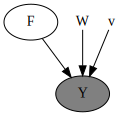

In [7]:
data = torch.ones(D)
pyro.render_model(model, model_args=(data,), render_params=True)

In [8]:
def guide(data):
    mean_q = pyro.param("mean_q", torch.zeros((N, L)))
    sigma_q = pyro.param("sigma_q", torch.ones((N, L)),
                        constraint=constraints.positive)
    pyro.sample("F", dist.Normal(mean_q, sigma_q).to_event())
    return mean_q, sigma_q

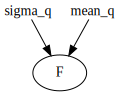

In [9]:
pyro.render_model(guide, model_args=(data,), render_params=True)

In [10]:
adam_params = {"lr": 1e-1, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

In [11]:
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [12]:
# do gradient steps
losses = []
for step in range(500):
    elbo = svi.step(Y)
    losses.append(elbo)

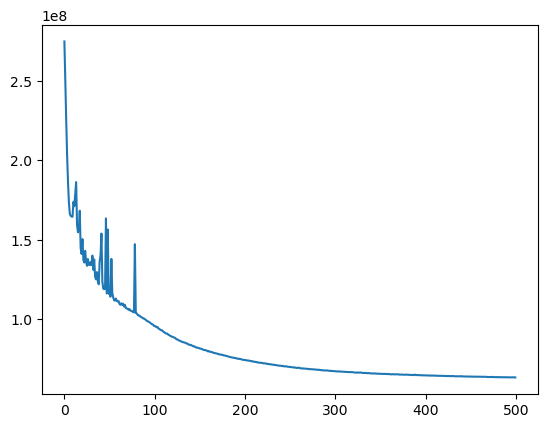

In [13]:
plt.plot(losses)

In [22]:
serving_model = infer_discrete(model, first_available_dim=-1)
W, F = serving_model(Y)

/Users/luisfcd/opt/miniconda3/envs/nsf/lib/python3.9/site-packages/pyro/infer/discrete.py:98: UserWarning: infer_discrete found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}.
  warnings.warn(


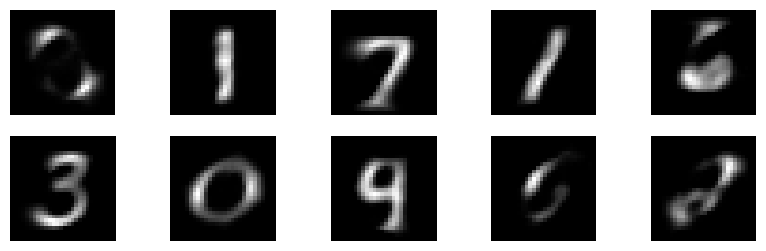

In [21]:
plt.figure(figsize=(10, 3))
for i in range(L):
    plt.subplot(2, 5, i+1)
    loading = W[:, i].detach().cpu().numpy()
    plt.imshow(loading.reshape(28, 28), cmap='gray')
    plt.axis('off')

In [18]:
qF, _ = guide(Y)
qF = qF.detach().cpu().numpy()

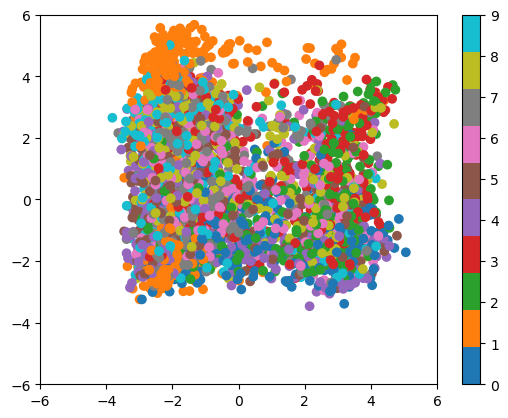

In [23]:
plt.scatter(qF[:, 0], qF[:, 1], c=y_train, cmap='tab10')
plt.ylim([-6, 6])
plt.xlim([-6, 6])
plt.colorbar()